imports

In [277]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import gc


paths and globals definitions

In [278]:
"""run this if you are working from google colab!!"""
# from google.colab import drive
# drive.mount('/content/gdrive')
# code_dir = "/content/gdrive/MyDrive/neural network project"

'run this if you are working from google colab!!'

In [279]:
"""run this if you are working from your local computer!!"""
code_dir = os.getcwd()

In [280]:
############## TENSORBOARD ########################
writer = SummaryWriter("runs/PNEUMOTHORAX")
###################################################

data_dir = os.path.join(code_dir, "Data")
class_file_path = os.path.join(code_dir, "train_data.csv")

PNEUMOTHORAX = 1
NOT_PNEUMOTHORAX = 0
classes = {PNEUMOTHORAX, NOT_PNEUMOTHORAX}
num_classes = len(classes)

classification_file = pd.read_csv(class_file_path, header=0)

# Hyper-parameters
batch_size = 8
num_workers = 0
epochs = 10
learning_rate = 0.01
image_size = 200


dataset definition

In [281]:
class PneumDataset(Dataset):
    def __init__(self, data_path, images_paths, labels, transform):
        # init custom dataset attributes
        self.data_path = data_path
        self.X_images = images_paths
        self.y_labels = labels
        self.transform = transform

    def __len__(self):
        # len of the dataset
        return len(self.X_images)

    def __getitem__(self, index):
        # get specific sample by index
        img_path = self.X_images[index]
        label = self.y_labels[index]

        # opening the image
        path = os.path.join(self.data_path, img_path)
        image = Image.open(path)
        image = image.convert("RGB")
        
        # converting x,y to tensors
        image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        label = label.view(1)
        return image, label

loading and splitting the data

One batch images shape: torch.Size([8, 3, 200, 200])
One batch labels shape: torch.Size([8, 1])


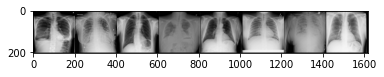

In [282]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

images_paths = np.asarray(classification_file["file_name"])
images_targets = np.asarray(classification_file["target"])

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(images_paths, images_targets, stratify=images_targets, random_state = 50)

# transform
transform = transforms.Compose([transforms.Resize(image_size),
                                # transforms.CenterCrop(image_size - 10),
                                transforms.ToTensor()])

# create dataloaders
train_dataset = PneumDataset(data_dir, X_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)

test_dataset = PneumDataset(data_dir, X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers)

# get some random training images
dataiter = iter(train_loader)
example_images, example_labels = dataiter.next()  # random batch

# batch shapes
print(f'One batch images shape: {example_images.shape}')
print(f'One batch labels shape: {example_labels.shape}')

# show images
img_grid = torchvision.utils.make_grid(example_images)
imshow(img_grid)

############## TENSORBOARD ########################
writer.add_image('PNEUMOTHORAX image grid', img_grid)
###################################################


model definition

In [283]:
class PneumNet(nn.Module):
    def __init__(self):
        super(PneumNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=20)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=20)
        self.fc1 = nn.Linear(in_features =16*35*35, out_features=100 )
        self.fc2 = nn.Linear(in_features=100, out_features = 50)
        self.fc3 = nn.Linear(in_features=50, out_features=1)


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(torch.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        # print(x.shape)
        x = torch.relu(self.fc2(x))
        # print(x.shape)
        x = torch.sigmoid(self.fc3(x))
        # print(x.shape)
        return x


loss, optimizer definition 

In [284]:
# device
device = "cpu"
if (torch.cuda.is_available()):
    gc.collect()
    torch.cuda.empty_cache()
    device = "cuda"
print(f"Working on device: {device}")

# model
model = PneumNet().to(device)

# loss and optimizer
criterion = nn.BCELoss()  # binary cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

############## TENSORBOARD ########################
writer.add_graph(model, example_images.to(device))
###################################################


Working on device: cuda


train function

In [286]:
def train(data_loader, model, optimizer, device, epochs, samples_num):    
    model.train()
    
    num_steps = len(train_loader)
    running_loss = 0.0 
    running_correct = 0.0
    threshold = 0.6
    
    for epoch in range(epochs):
        for i, data in enumerate(data_loader):
            (images, labels) = data
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predicted = outputs > threshold
            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()
            
            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{num_steps}], Loss: {loss.item():.4f}')
                ############## TENSORBOARD ########################
                writer.add_scalar('training loss', running_loss /
                                  100, epoch * num_steps + i)
                running_accuracy = running_correct / 100 / predicted.size(0)
                writer.add_scalar('accuracy', running_accuracy,
                                  epoch * num_steps + i)
                running_correct = 0
                running_loss = 0.0
                ###################################################


print("starting training")
train(train_loader, model, optimizer, device, epochs, len(train_dataset))


starting training
Epoch [1/10], Step [10/190], Loss: 0.4213
Epoch [1/10], Step [20/190], Loss: 0.7189
Epoch [1/10], Step [30/190], Loss: 0.6838
Epoch [1/10], Step [40/190], Loss: 0.5841
Epoch [1/10], Step [50/190], Loss: 0.3575
Epoch [1/10], Step [60/190], Loss: 0.3724
Epoch [1/10], Step [70/190], Loss: 0.4075
Epoch [1/10], Step [80/190], Loss: 0.9847
Epoch [1/10], Step [90/190], Loss: 0.4551
Epoch [1/10], Step [100/190], Loss: 0.7837
Epoch [1/10], Step [110/190], Loss: 0.6112
Epoch [1/10], Step [120/190], Loss: 0.3672
Epoch [1/10], Step [130/190], Loss: 0.4023
Epoch [1/10], Step [140/190], Loss: 0.6762
Epoch [1/10], Step [150/190], Loss: 0.4038
Epoch [1/10], Step [160/190], Loss: 0.3473
Epoch [1/10], Step [170/190], Loss: 0.4613
Epoch [1/10], Step [180/190], Loss: 0.4553
Epoch [1/10], Step [190/190], Loss: 0.5469
Epoch [2/10], Step [10/190], Loss: 0.3762
Epoch [2/10], Step [20/190], Loss: 0.3970
Epoch [2/10], Step [30/190], Loss: 0.6616
Epoch [2/10], Step [40/190], Loss: 0.6462
Epoch 

test function

In [292]:
def test(data_loader, model, device):
    model.eval()
    # init lists to store targets and outputs
    class_labels = []
    class_preds = []
    threshold = 0.6
    # no_grad context
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data in data_loader:
            (images, labels) = data

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            # predict
            outputs = model(images)
            
            predicted = outputs > threshold
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            class_preds.append(outputs)
            class_labels.append(predicted)
            
    return class_preds, class_labels, n_samples, n_correct


class_preds, class_labels, n_samples, n_correct = test(test_loader, model, device=device)

class_preds = torch.cat(class_preds)
class_labels = torch.cat(class_labels)

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc} %')


############## TENSORBOARD ########################
for i in classes:
    labels_i = class_labels == i
    preds_i = class_preds[:, i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
writer.close()
###################################################


Accuracy of the network on the 10000 test images: 77.51479289940828 %


ValueError: weights should have the same shape as a.

In [ ]:
# def split_data():
#     """
#     ONLY RUN ONCE!!!
#     split the data to 2 class directory using the information from the data file
#     """

#     for row, file_name in enumerate(classification_file["file_name"]):
#       lable = classification_file["target"][row]
#       original_path = os.path.join(data_dir, file_name)
      
#       if lable == PENUMOTHORAX:
#         dest_path = os.path.join(Pneumothorax_dir, file_name)
#       elif lable == NOT_PENUMOTHORAX:
#         dest_path = os.path.join(not_Pneumothorax_dir, file_name)

#       shutil.copy(original_path,dest_path)




In [ ]:
# # Train and evaluate functions 

# def train(data_loader, model, optimizer, device):
#     """
#     training for one epoch with selected model and params
#      data_loader:  pytorch dataloader
#      model: pytorch model
#      optimizer: optimizer 
#      device: cuda/cpu
#     """
#     # set training mode 
#     model.train()
#     # go over every batch of data in data loader
#     for data in data_loader:
#         inputs = data["image"]
#         targets = data["targets"]
#         # move inputs/targets to cuda/cpu device
#         inputs = inputs.to(device, dtype=torch.float)
#         targets = targets.to(device, dtype=torch.float)
#         # zero grad the optimizer
#         optimizer.zero_grad()
#         # do the forward step of model
#         outputs = model(inputs)
#         # calculate loss
#         loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
#         # backward step the loss
#         loss.backward()
#         # step optimizer
#         optimizer.step()
        
# def evaluate(data_loader, model, device):
#     """
#     Evaluation for one epoch
#     data_loader: this is the pytorch dataloader
#     model: pytorch model
#     device: cuda/cpu
#     """
#     # put model in evaluation mode
#     model.eval()
#     # init lists to store targets and outputs
#     final_targets = []
#     final_outputs = []
#     # no_grad context
#     with torch.no_grad():
#         for data in data_loader:
#             inputs = data["image"]
#             targets = data["targets"]
#             inputs = inputs.to(device, dtype=torch.float)
#             targets = targets.to(device, dtype=torch.float)
#             # generate prediction
#             output = model(inputs)
#             # convert targets and outputs to lists
#             targets = targets.detach().cpu().numpy().tolist()
#             output = output.detach().cpu().numpy().tolist()
#             # extend the original list
#             final_targets.extend(targets)
#             final_outputs.extend(output)
            
#     return final_outputs, final_targets
# # train and print auc score for all epochs
# for epoch in tqdm(range(EPOCHS)):
#     # train 
#     train(train_loader, model, optimizer, device=device)
#     # predict 
#     predictions, valid_targets = evaluate(valid_loader, model, device=device)
#     # metrics 
#     roc_auc = metrics.roc_auc_score(valid_targets, predictions)
#     print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}")

    